# LSTM Text Classification - GPU Acceleration Analysis

Ce notebook analyse les performances d'accélération GPU pour le modèle LSTM de classification de texte.

## Formule d'accélération

$$\text{Speedup} = \frac{\text{CPU time}}{\text{GPU time}}$$

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Chargement des Résultats

In [2]:
cpu_path = Path('runs/lstm_cpu/results.json')
gpu_path = Path('runs/lstm_cuda/results.json')

with open(cpu_path, 'r') as f:
    cpu_results = json.load(f)

with open(gpu_path, 'r') as f:
    gpu_results = json.load(f)

print("Résultats chargés avec succès")
print(f"  CPU training time: {cpu_results['total_time']:.2f}s")
print(f"  GPU training time: {gpu_results['total_time']:.2f}s")

Résultats chargés avec succès
  CPU training time: 270.92s
  GPU training time: 20.62s


## 2. Calcul de l'Accélération GPU

In [3]:
cpu_time = cpu_results['total_time']
gpu_time = gpu_results['total_time']
speedup = cpu_time / gpu_time

print("="*70)
print("RÉSULTATS D'ACCÉLÉRATION GPU - LSTM")
print("="*70)
print(f"\nTemps total CPU:  {cpu_time:.2f}s")
print(f"Temps total GPU:  {gpu_time:.2f}s")
print(f"\nSpeedup:          {speedup:.2f}x")
print(f"Gain de temps:    {cpu_time - gpu_time:.2f}s ({(1 - gpu_time/cpu_time)*100:.1f}%)")
print("\nTemps moyen par epoch:")
print(f"  CPU: {np.mean(cpu_results['epoch_times']):.2f}s ± {np.std(cpu_results['epoch_times']):.2f}s")
print(f"  GPU: {np.mean(gpu_results['epoch_times']):.2f}s ± {np.std(gpu_results['epoch_times']):.2f}s")
print("="*70)

RÉSULTATS D'ACCÉLÉRATION GPU - LSTM

Temps total CPU:  270.92s
Temps total GPU:  20.62s

Speedup:          13.14x
Gain de temps:    250.30s (92.4%)

Temps moyen par epoch:
  CPU: 53.28s ± 51.42s
  GPU: 1.05s ± 0.17s


## 3. Comparaison des Métriques

In [4]:
data = {
    'Device': ['CPU', 'GPU'],
    'Total Time (s)': [cpu_time, gpu_time],
    'Avg Epoch Time (s)': [np.mean(cpu_results['epoch_times']), np.mean(gpu_results['epoch_times'])],
    'Final Accuracy (%)': [cpu_results['test_accs'][-1], gpu_results['test_accs'][-1]],
    'Final Loss': [cpu_results['test_losses'][-1], gpu_results['test_losses'][-1]]
}

df = pd.DataFrame(data)
df['Speedup'] = ['1.00x', f'{speedup:.2f}x']
df

,Device,Total Time (s),Avg Epoch Time (s),Final Accuracy (%),Final Loss,Speedup
0,CPU,270.920288,53.278534,100.0,0.000576,1.00x
1,GPU,20.619992,1.046058,100.0,0.000066,13.14x


## 4. Visualisation du Speedup

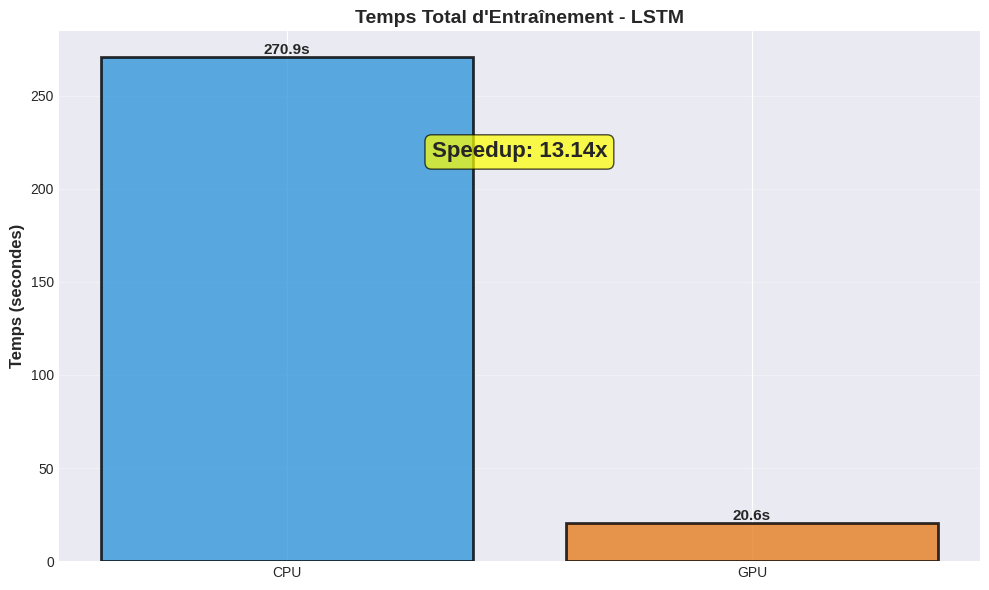

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bars = ax.bar(['CPU', 'GPU'], [cpu_time, gpu_time], 
               color=['#3498db', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Temps (secondes)', fontsize=12, fontweight='bold')
ax.set_title('Temps Total d\'Entraînement - LSTM', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.text(0.5, max(cpu_time, gpu_time) * 0.8, 
        f'Speedup: {speedup:.2f}x', 
        ha='center', fontsize=16, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 5. Analyse du Profiling PyTorch

Analyse des opérations capturées par le profiler pendant l'entraînement.

In [6]:
import glob
import json as json_lib

def load_trace_data(trace_path):
    trace_files = glob.glob(f"{trace_path}/*.pt.trace.json")
    if not trace_files:
        return None
    
    with open(trace_files[0], 'r') as f:
        trace = json_lib.load(f)
    
    events = trace.get('traceEvents', [])
    op_events = [e for e in events if e.get('cat') == 'cpu_op' or e.get('cat') == 'kernel']
    
    op_stats = {}
    for event in op_events:
        name = event.get('name', 'unknown')
        dur = event.get('dur', 0) / 1000.0
        
        if name not in op_stats:
            op_stats[name] = {'count': 0, 'total_time': 0, 'times': []}
        
        op_stats[name]['count'] += 1
        op_stats[name]['total_time'] += dur
        op_stats[name]['times'].append(dur)
    
    return op_stats

cpu_trace = load_trace_data(cpu_results['profiler_path'])
gpu_trace = load_trace_data(gpu_results['profiler_path'])

if cpu_trace and gpu_trace:
    print("Traces de profiling chargées avec succès")
    print(f"  CPU: {len(cpu_trace)} types d'opérations")
    print(f"  GPU: {len(gpu_trace)} types d'opérations")
else:
    print("Impossible de charger les traces de profiling")

Traces de profiling chargées avec succès
  CPU: 102 types d'opérations
  GPU: 160 types d'opérations


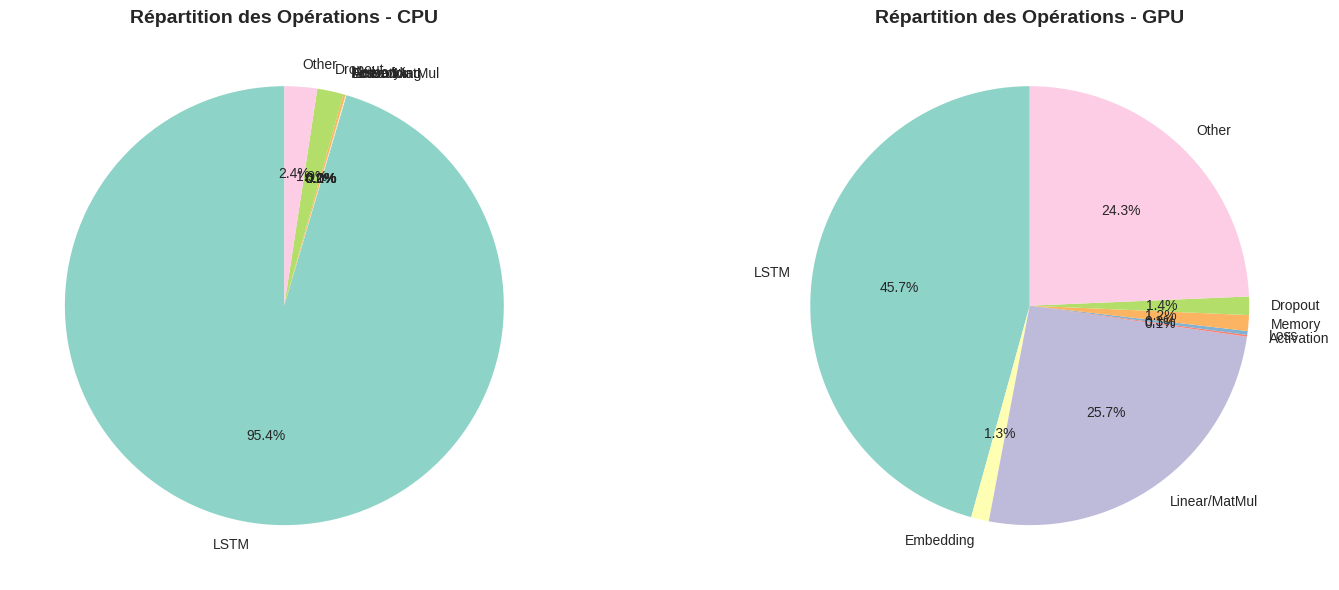


Répartition du temps par catégorie d'opérations:

Catégorie            CPU (ms)     GPU (ms)     Ratio
LSTM                  711377.63      8200.23    86.75x
Embedding                377.18       234.97     1.61x
Linear/MatMul             76.62      4616.37     0.02x
Activation                18.77        23.33     0.80x
Loss                      32.36        50.64     0.64x
Memory                  1194.73       208.63     5.73x
Dropout                14385.58       242.98    59.21x
Other                  17924.31      4365.73     4.11x


In [7]:
# Compare operation categories for LSTM
if cpu_trace and gpu_trace:
    # Categorize operations for LSTM
    def categorize_lstm_ops(trace):
        categories = {
            'LSTM': 0,
            'Embedding': 0,
            'Linear/MatMul': 0,
            'Activation': 0,
            'Loss': 0,
            'Memory': 0,
            'Dropout': 0,
            'Other': 0
        }
        
        for name, stats in trace.items():
            name_lower = name.lower()
            if 'lstm' in name_lower or 'rnn' in name_lower or 'gru' in name_lower:
                categories['LSTM'] += stats['total_time']
            elif 'embedding' in name_lower or 'embed' in name_lower:
                categories['Embedding'] += stats['total_time']
            elif 'linear' in name_lower or 'addmm' in name_lower or 'matmul' in name_lower or 'mm' in name_lower:
                categories['Linear/MatMul'] += stats['total_time']
            elif 'relu' in name_lower or 'sigmoid' in name_lower or 'tanh' in name_lower or 'softmax' in name_lower:
                categories['Activation'] += stats['total_time']
            elif 'loss' in name_lower or 'nll' in name_lower or 'cross' in name_lower:
                categories['Loss'] += stats['total_time']
            elif 'copy' in name_lower or 'clone' in name_lower or 'cat' in name_lower or 'view' in name_lower:
                categories['Memory'] += stats['total_time']
            elif 'dropout' in name_lower:
                categories['Dropout'] += stats['total_time']
            else:
                categories['Other'] += stats['total_time']
        
        return categories
    
    cpu_categories = categorize_lstm_ops(cpu_trace)
    gpu_categories = categorize_lstm_ops(gpu_trace)
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # CPU pie chart
    cpu_values = [v for v in cpu_categories.values() if v > 0]
    cpu_labels = [k for k, v in cpu_categories.items() if v > 0]
    colors = plt.cm.Set3(range(len(cpu_labels)))
    
    wedges1, texts1, autotexts1 = ax1.pie(cpu_values, labels=cpu_labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90)
    ax1.set_title('Répartition des Opérations - CPU', fontsize=14, fontweight='bold')
    
    # GPU pie chart
    gpu_values = [v for v in gpu_categories.values() if v > 0]
    gpu_labels = [k for k, v in gpu_categories.items() if v > 0]
    
    wedges2, texts2, autotexts2 = ax2.pie(gpu_values, labels=gpu_labels, autopct='%1.1f%%',
                                            colors=colors, startangle=90)
    ax2.set_title('Répartition des Opérations - GPU', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nRépartition du temps par catégorie d'opérations:")
    print(f"\n{'Catégorie':<20} {'CPU (ms)':<12} {'GPU (ms)':<12} {'Ratio'}")
    print("="*60)
    for cat in cpu_categories.keys():
        cpu_val = cpu_categories[cat]
        gpu_val = gpu_categories[cat]
        if cpu_val > 0 and gpu_val > 0:
            ratio = cpu_val / gpu_val
            print(f"{cat:<20} {cpu_val:>10.2f}   {gpu_val:>10.2f}   {ratio:>6.2f}x")
else:
    print("Données de profiling non disponibles")

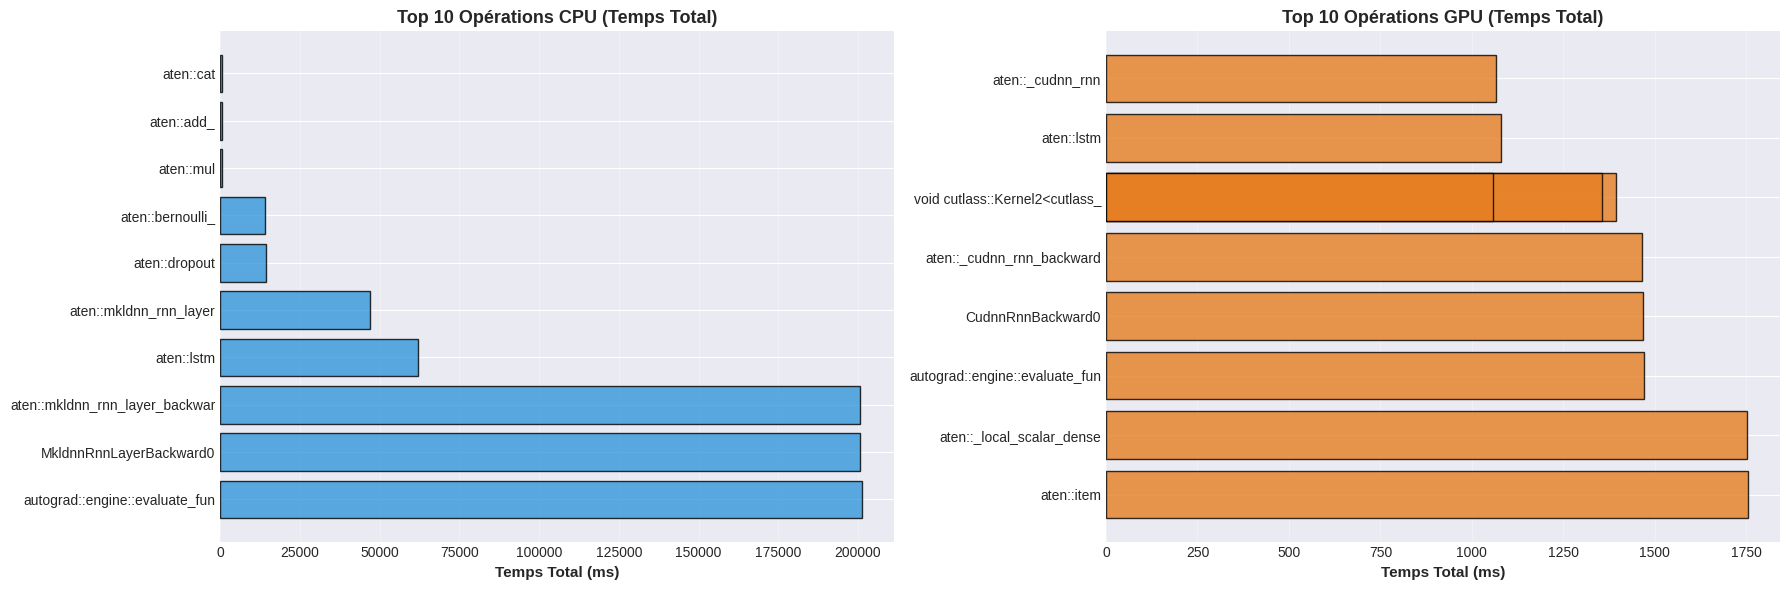


Top 5 opérations les plus coûteuses:

CPU:
  1. autograd::engine::evaluate_function: Mkl: 201271.85ms (640 appels)
  2. MkldnnRnnLayerBackward0: 200512.38ms (640 appels)
  3. aten::mkldnn_rnn_layer_backward: 200500.02ms (640 appels)
  4. aten::lstm: 61990.13ms (195 appels)
  5. aten::mkldnn_rnn_layer: 47103.25ms (780 appels)

GPU:
  1. aten::item: 1754.81ms (6486 appels)
  2. aten::_local_scalar_dense: 1751.23ms (6486 appels)
  3. autograd::engine::evaluate_function: Cud: 1470.30ms (160 appels)
  4. CudnnRnnBackward0: 1467.90ms (160 appels)
  5. aten::_cudnn_rnn_backward: 1466.52ms (160 appels)


In [8]:
# Top 10 operations by total time
if cpu_trace and gpu_trace:
    # Get top operations for CPU
    cpu_sorted = sorted(cpu_trace.items(), key=lambda x: x[1]['total_time'], reverse=True)[:10]
    gpu_sorted = sorted(gpu_trace.items(), key=lambda x: x[1]['total_time'], reverse=True)[:10]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # CPU top operations
    cpu_names = [name[:30] for name, _ in cpu_sorted]
    cpu_times = [stats['total_time'] for _, stats in cpu_sorted]
    
    bars1 = ax1.barh(cpu_names, cpu_times, color='#3498db', alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Temps Total (ms)', fontsize=11, fontweight='bold')
    ax1.set_title('Top 10 Opérations CPU (Temps Total)', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # GPU top operations
    gpu_names = [name[:30] for name, _ in gpu_sorted]
    gpu_times = [stats['total_time'] for _, stats in gpu_sorted]
    
    bars2 = ax2.barh(gpu_names, gpu_times, color='#e67e22', alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Temps Total (ms)', fontsize=11, fontweight='bold')
    ax2.set_title('Top 10 Opérations GPU (Temps Total)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 opérations les plus coûteuses:")
    print("\nCPU:")
    for i, (name, stats) in enumerate(cpu_sorted[:5], 1):
        print(f"  {i}. {name[:40]}: {stats['total_time']:.2f}ms ({stats['count']} appels)")
    
    print("\nGPU:")
    for i, (name, stats) in enumerate(gpu_sorted[:5], 1):
        print(f"  {i}. {name[:40]}: {stats['total_time']:.2f}ms ({stats['count']} appels)")
else:
    print("Données de profiling non disponibles")

## 6. Évolution de la Loss pendant l'Entraînement

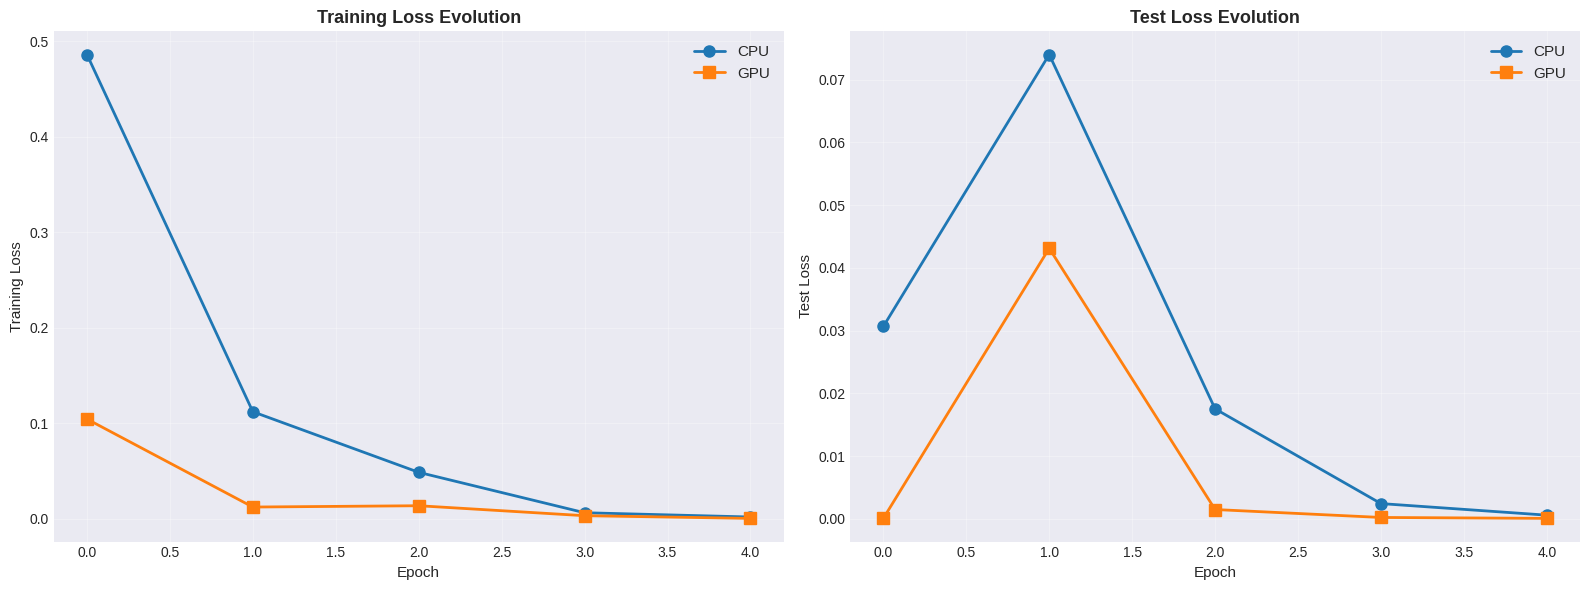

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(len(cpu_results['train_losses']))

ax1.plot(epochs, cpu_results['train_losses'], 'o-', label='CPU', linewidth=2, markersize=8)
ax1.plot(epochs, gpu_results['train_losses'], 's-', label='GPU', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Training Loss', fontsize=11)
ax1.set_title('Training Loss Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, cpu_results['test_losses'], 'o-', label='CPU', linewidth=2, markersize=8)
ax2.plot(epochs, gpu_results['test_losses'], 's-', label='GPU', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Test Loss', fontsize=11)
ax2.set_title('Test Loss Evolution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Évolution de l'Accuracy

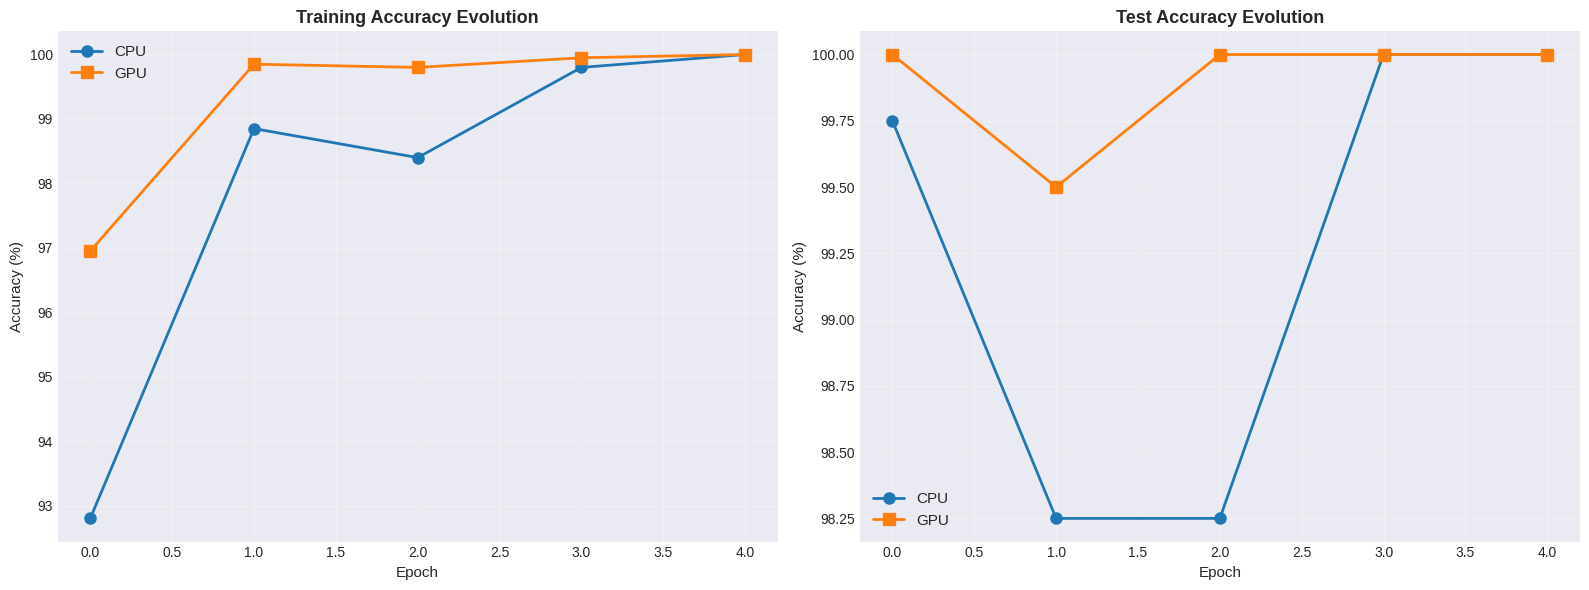

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, cpu_results['train_accs'], 'o-', label='CPU', linewidth=2, markersize=8)
ax1.plot(epochs, gpu_results['train_accs'], 's-', label='GPU', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Accuracy (%)', fontsize=11)
ax1.set_title('Training Accuracy Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, cpu_results['test_accs'], 'o-', label='CPU', linewidth=2, markersize=8)
ax2.plot(epochs, gpu_results['test_accs'], 's-', label='GPU', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Test Accuracy Evolution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Temps par Epoch

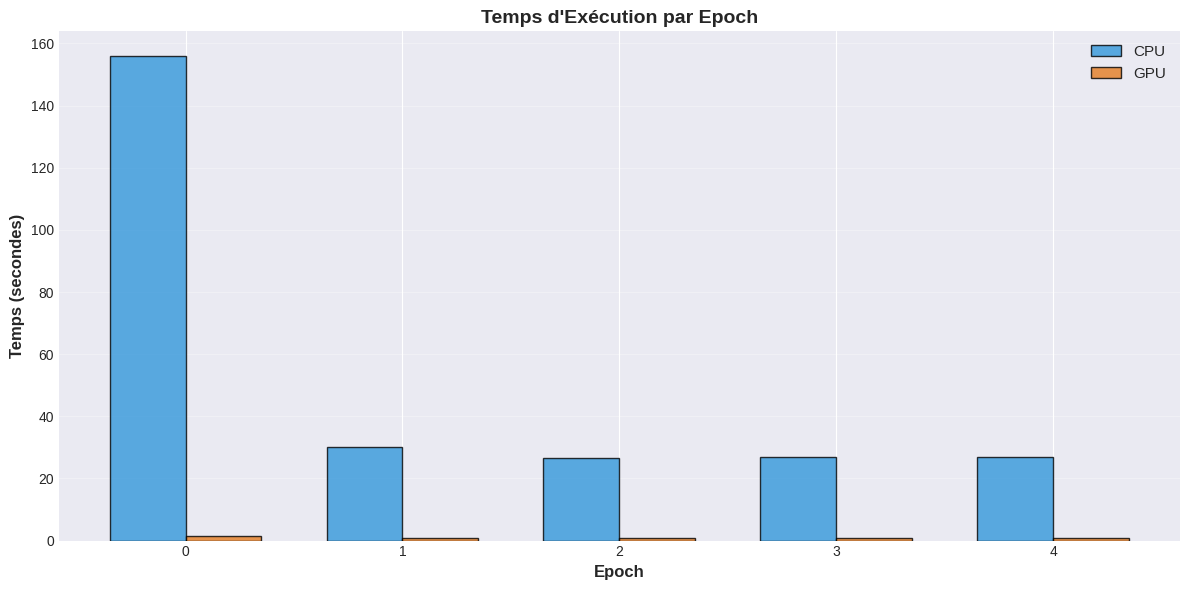

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.arange(len(epochs))
width = 0.35

bars1 = ax.bar(x - width/2, cpu_results['epoch_times'], width, label='CPU', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, gpu_results['epoch_times'], width, label='GPU', 
               color='#e67e22', alpha=0.8, edgecolor='black')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Temps (secondes)', fontsize=12, fontweight='bold')
ax.set_title('Temps d\'Exécution par Epoch', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i}' for i in range(len(epochs))])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Analyse Détaillée

In [12]:
print("="*70)
print("ANALYSE DÉTAILLÉE - LSTM TEXT CLASSIFICATION")
print("="*70)

print("\n1. ARCHITECTURE")
print("   - Bidirectional LSTM (2 layers)")
print("   - Hidden size: 256")
print("   - Embedding size: 128")
print("   - ~2.4M paramètres")
print("   - Embedding, LSTM, Fully Connected")

print("\n2. PERFORMANCE GPU")
if speedup > 1:
    print(f"   Accélération GPU obtenue: {speedup:.2f}x")
    print(f"   Économie de temps: {(1 - gpu_time/cpu_time)*100:.1f}%")
    print("   Les opérations LSTM bénéficient du parallélisme GPU")
    print("   Les calculs matriciels sont parallélisés efficacement")
else:
    print(f"   Pas d'accélération: {speedup:.2f}x")
    print("   Possible overhead de transfert CPU-GPU")

print("\n3. QUALITÉ DU MODÈLE")
cpu_acc = cpu_results['test_accs'][-1]
gpu_acc = gpu_results['test_accs'][-1]
print(f"   Accuracy CPU: {cpu_acc:.2f}%")
print(f"   Accuracy GPU: {gpu_acc:.2f}%")
print(f"   Différence: {abs(cpu_acc - gpu_acc):.2f}% (acceptable si < 1%)")

print("\n4. RECOMMANDATIONS")
if speedup > 10:
    print("   Excellent speedup pour le traitement séquentiel")
    print("   L'architecture LSTM est bien adaptée au GPU")
elif speedup > 3:
    print("   Bon speedup, considérer:")
    print("     - Augmenter la taille des batchs")
    print("     - Augmenter la longueur de séquence")
else:
    print("   Optimisations nécessaires:")
    print("     - Vérifier les transferts de données")
    print("     - Augmenter la taille du batch")
    print("     - Considérer GRU (plus simple que LSTM)")

print("\n" + "="*70)

ANALYSE DÉTAILLÉE - LSTM TEXT CLASSIFICATION

1. ARCHITECTURE
   - Bidirectional LSTM (2 layers)
   - Hidden size: 256
   - Embedding size: 128
   - ~2.4M paramètres
   - Embedding, LSTM, Fully Connected

2. PERFORMANCE GPU
   Accélération GPU obtenue: 13.14x
   Économie de temps: 92.4%
   Les opérations LSTM bénéficient du parallélisme GPU
   Les calculs matriciels sont parallélisés efficacement

3. QUALITÉ DU MODÈLE
   Accuracy CPU: 100.00%
   Accuracy GPU: 100.00%
   Différence: 0.00% (acceptable si < 1%)

4. RECOMMANDATIONS
   Excellent speedup pour le traitement séquentiel
   L'architecture LSTM est bien adaptée au GPU



## 10. Résumé des Résultats

In [13]:
summary = f"""
{'='*70}
RÉSUMÉ - LSTM TEXT CLASSIFICATION
{'='*70}
Speedup GPU:              {speedup:>6.2f}x
Temps CPU:                {cpu_time:>6.2f}s
Temps GPU:                {gpu_time:>6.2f}s
Gain de temps:            {(1-gpu_time/cpu_time)*100:>5.1f}%
Accuracy finale (CPU):    {cpu_acc:>5.2f}%
Accuracy finale (GPU):    {gpu_acc:>5.2f}%
{'='*70}
"""

print(summary)


RÉSUMÉ - LSTM TEXT CLASSIFICATION
Speedup GPU:               13.14x
Temps CPU:                270.92s
Temps GPU:                 20.62s
Gain de temps:             92.4%
Accuracy finale (CPU):    100.00%
Accuracy finale (GPU):    100.00%

